<a href="https://colab.research.google.com/github/flrain2/Study/blob/main/create_5fold_each_num_fnl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Keras Data Split 제공 함수
### 1) 2개 그룹 생성(Train/Test)
### 2) 번호별 비율 제어 어려움(random)
- StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
- RepeatedStratifiedKFold(n_splits=2, n_repeats=2,random_state=3684)
- KFold(n_splits=2, random_state=None, shuffle=False)


## => Cross Validation Set Manual 생성
###1) 번호별 5개 fold 생성
###2) 20가지 경우의 수 만큼 Dataset 생성
- Train(60%) / Validation(20%) / Test(20%)


In [ ]:
import torch
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

import itertools

# import tensorflow as tf
# from torch import nn
# import torchvision.transforms as tr
# from sklearn.model_selection import KFold

In [ ]:
DataDir = '/content/drive/MyDrive/Data/'
#MdlDir = '/content/drive/MyDrive/Algorithm/NN/Mnist_Load_NN/Pytorch/Model/'

## 1. MNIST Download -> Train/Test Data Concate
 - datasets.MINST
 - ConcatDataset

In [ ]:
## MNIST Data down 받기

# 공개 데이터셋에서 학습 데이터를 내려받습니다.
train = datasets.MNIST(
    root=DataDir,
    train=True,
    download=True,
    transform=ToTensor(),
)

# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
test = datasets.MNIST(
    root=DataDir,
    train=False,
    download=True,
    transform=ToTensor(),
)
# 데이터 합치기
tot_dataset = ConcatDataset([train, test])
print("length of training_data: ", len(train))
print("length of test_data: ", len(test))
print("length of tot_dataset: ", len(tot_dataset))

length of training_data:  60000
length of test_data:  10000
length of tot_dataset:  70000


In [ ]:
print("train:", type(train), "tot_dataset", type(tot_dataset))

train: <class 'torchvision.datasets.mnist.MNIST'> tot_dataset <class 'torch.utils.data.dataset.ConcatDataset'>


# 2. 0~9 번호별 fold 5개 생성 
### 1) Image Data/Label 분리
### 2) 숫자(0~9) 및 Image Data/Label별 5개 fold 만들기
### 3) 5개 fold 만들기(0~9번호 합치기)
#### 참고)생성 dataset(100개) : 숫자(10개) * fold(5개) * Image data/label(2개)
- chunk : fold 생성
- globals() : 변수별 가변인자 

In [ ]:
# Image Data, label numpy 만들기
X, label = zip(*tot_dataset) #unzip
X_np = np.array(X)
label_np = np.array(label)

# 0~9 번호별 건수
number, counts = np.unique(label_np, return_counts=True)
uniq_cnt = dict(zip(number, counts))
uniq_cnt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing im

{0: 6903,
 1: 7877,
 2: 6990,
 3: 7141,
 4: 6824,
 5: 6313,
 6: 6876,
 7: 7293,
 8: 6825,
 9: 6958}

In [ ]:
# 번호별 5개 fold image data, labe 만들기
for number in range(10):
# label index, label 값, 이미지 data 생성
  # label
  idx_label = np.where(label_np == number)[0]
  idx_lb_data = label_np[idx_label]
  # Image Data
  idx_data_tmp = X_np[idx_label]
  idx_data_np=np.vstack(idx_data_tmp).astype(np.float)
  idx_data = torch.Tensor(idx_data_np)

# 5개 fold Image data 만들기 : 예)번호 0, 첫번째 fold Image Data -> idx_data_0_0
  # 5개 fold 지정
  chunks = idx_data.chunk(5)

  # fold별 Image Data 생성
  for idx, data in enumerate(chunks):
    globals()["idx_data_"+str(number)+"_"+str(idx)] = data

# 5개 fold label data 만들기 : 예)번호 0, 첫번째 fold label Data -> idx_lb_data_0_0     
  # fold별 Image Data 건수정보 list 만들기
  num_idx = [len(globals()["idx_data_"+str(number)+"_0"]),
            len(globals()["idx_data_"+str(number)+"_1"]),
            len(globals()["idx_data_"+str(number)+"_2"]),
            len(globals()["idx_data_"+str(number)+"_3"]),
            len(globals()["idx_data_"+str(number)+"_4"])]

  # fold별 Image Data건수 만큼 label Data 만들기
  for idx, num in enumerate(num_idx):
    globals()["idx_lb_data_"+str(number)+"_"+str(idx)] = idx_lb_data[:num]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


In [ ]:
#  fold별로 합치기 : Image data/Label별 5개 fold 생성
for fold in range(5):
  # Image Data
  globals()["idx_data_fold_"+str(fold)] = torch.cat((globals()["idx_data_0_"+str(fold)],
                                                      globals()["idx_data_1_"+str(fold)],
                                                      globals()["idx_data_2_"+str(fold)],
                                                      globals()["idx_data_3_"+str(fold)],
                                                      globals()["idx_data_4_"+str(fold)],
                                                      globals()["idx_data_5_"+str(fold)],
                                                      globals()["idx_data_6_"+str(fold)],
                                                      globals()["idx_data_7_"+str(fold)],
                                                      globals()["idx_data_8_"+str(fold)],
                                                      globals()["idx_data_9_"+str(fold)])
                                                      ,0)
  # label Data   
  globals()["idx_lb_fold_"+str(fold)] = np.concatenate((globals()["idx_lb_data_0_"+str(fold)],
                                                    globals()["idx_lb_data_1_"+str(fold)],
                                                    globals()["idx_lb_data_2_"+str(fold)],
                                                    globals()["idx_lb_data_3_"+str(fold)],
                                                    globals()["idx_lb_data_4_"+str(fold)],
                                                    globals()["idx_lb_data_5_"+str(fold)],
                                                    globals()["idx_lb_data_6_"+str(fold)],
                                                    globals()["idx_lb_data_7_"+str(fold)],
                                                    globals()["idx_lb_data_8_"+str(fold)],
                                                    globals()["idx_lb_data_9_"+str(fold)]), axis = 0)
    

#3. 생성 Data 검증
###1) 5개 fold data 건수합 = 전체 data 건수(7만개)
###2) 전체 vs. 각 fold별 번호 구성비 비교 
###3) 생성 data Image 출력
- Custome Datset Class : Image / Label Data 결합 

In [ ]:
# 5 fold 합계 = 전체 합계
tot_sum_data = 0
for i in range(5):
  tot_sum_data += len(globals()["idx_data_fold_"+str(i)])
  print("idx_data_fold_"+str(i), globals()["idx_data_fold_"+str(i)].shape, "tot_sum_data:", tot_sum_data)

tot_sum_label = 0
for i in range(5):
  tot_sum_label += len(globals()["idx_lb_fold_"+str(i)])
  print("idx_lb_fold_"+str(i), globals()["idx_lb_fold_"+str(i)].shape, "tot_sum:", tot_sum_label)

idx_data_fold_0 torch.Size([14004, 28, 28]) tot_sum_data: 14004
idx_data_fold_1 torch.Size([14004, 28, 28]) tot_sum_data: 28008
idx_data_fold_2 torch.Size([14004, 28, 28]) tot_sum_data: 42012
idx_data_fold_3 torch.Size([14004, 28, 28]) tot_sum_data: 56016
idx_data_fold_4 torch.Size([13984, 28, 28]) tot_sum_data: 70000
idx_lb_fold_0 (14004,) tot_sum: 14004
idx_lb_fold_1 (14004,) tot_sum: 28008
idx_lb_fold_2 (14004,) tot_sum: 42012
idx_lb_fold_3 (14004,) tot_sum: 56016
idx_lb_fold_4 (13984,) tot_sum: 70000


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


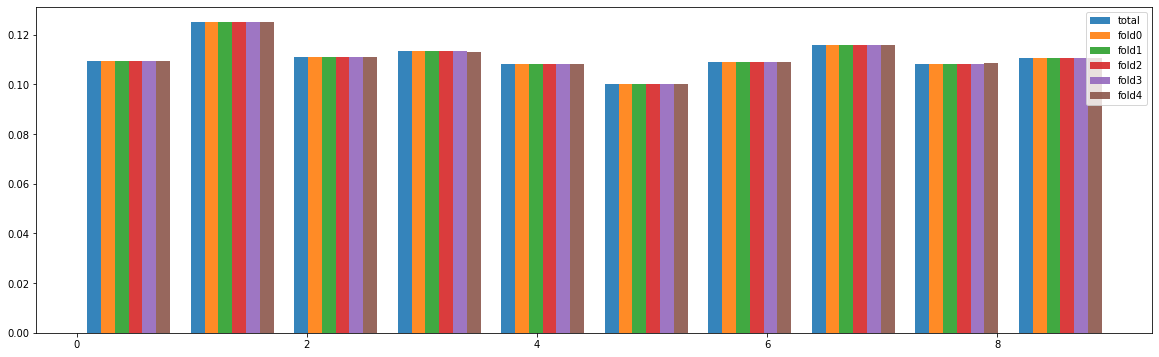

In [ ]:
# 번호별 구성비 비교
fig = plt.figure(figsize=(20,6))
plt.hist([label_np, idx_lb_fold_0, idx_lb_fold_1, idx_lb_fold_2, idx_lb_fold_3, idx_lb_fold_4], 
         bins = 10, density=True, alpha=0.9, label = ['total', 'fold0', 'fold1', 'fold2', 'fold3', 'fold4'])
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Custome Dataset 만들기
class CustomDataset(Dataset):
  def __init__(self, datarole, labelrole, transform=None):
    self.image_list = datarole
    self.class_list = labelrole
    self.transform = transform
    self.len = datarole.shape[0]
  def __len__(self):
    return self.len
  def __getitem__(self, idx):
    img = self.image_list[idx]    
    label = self.class_list[idx]
    return img, label

In [ ]:
# custome data 생성, dataloader : fold 1
custom_dataset = CustomDataset(idx_data_fold_1, idx_lb_fold_1)
dataloader = DataLoader(custom_dataset, batch_size=100, shuffle=True, drop_last=False)

In [ ]:
print(len(custom_dataset),len(dataloader))

14004 141


Feature batch shape: torch.Size([100, 28, 28])
Labels batch shape: torch.Size([100])


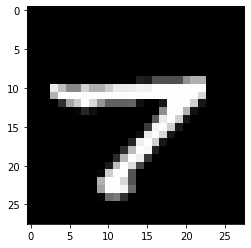

Label: 7


In [ ]:
# image 출력
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

#4. 5개 생성 fold 저장
- np.save

In [ ]:
 #path_data = "/content/drive/MyDrive/Data/MNIST/fold5/idx_data_fold_"
 #path_lb = "/content/drive/MyDrive/Data/MNIST/fold5/idx_lb_fold_"

# for idx in range(5):
#  globals()["idx_data_fold_"+str(idx)+"_np"] = data.numpy()  
#  np.save(path_data + str(idx), globals()["idx_data_fold_"+str(idx)+"_np"])
#  globals()["idx_lb_fold_"+str(idx)+"_np"] = data.numpy()  
#  np.save(path_lb+str(idx), globals()["idx_lb_fold_"+str(idx)+"_np"])  
for idx in range(5):
  globals()["idx_data_fold_"+str(idx)+"_np"] = data.numpy()  
  np.save(DataDir+"MNIST/fold5/idx_data_fold_"+ str(idx), globals()["idx_data_fold_"+str(idx)+"_np"])
  np.save(DataDir+"MNIST/fold5/idx_lb_fold_"+str(idx), globals()["idx_lb_fold_"+str(idx)])

#5. Cross Validation Set 생성(총 20개 set)
### - 5개 fold 활용(Train(60%), Validation(20%), Test(20%))
- itertools



In [ ]:
# 20개 Cross Validation Set별 Image Data / Label 파일 생성
print("fold_0:", len(idx_data_fold_0))
print("fold_1:", len(idx_data_fold_1))
print("fold_2:", len(idx_data_fold_2))
print("fold_3:", len(idx_data_fold_3))
print("fold_4:", len(idx_data_fold_4))
for idx, (train_idx, valid_idx, test_idx) in enumerate(result):
  # Image Data
  # Train
  globals()["data_trn_case_"+str(idx)] = torch.cat((globals()["idx_data_fold_"+train_idx[0]],
                                                  globals()["idx_data_fold_"+train_idx[1]],
                                                  globals()["idx_data_fold_"+train_idx[2]]),
                                                  0)
  # Validation
  globals()["data_vld_case_"+str(idx)] = globals()["idx_data_fold_"+valid_idx]
  # Test  
  globals()["data_tst_case_"+str(idx)] = globals()["idx_data_fold_"+test_idx]


  # Label Data
  # Train
  globals()["lb_trn_case_"+str(idx)] = np.concatenate((globals()["idx_lb_fold_"+train_idx[0]],
                                                  globals()["idx_lb_fold_"+train_idx[1]],
                                                  globals()["idx_lb_fold_"+train_idx[2]]),
                                                  axis = 0)
  # Validaiton  
  globals()["lb_vld_case_"+str(idx)] = globals()["idx_lb_fold_"+valid_idx]
  # Test
  globals()["lb_tst_case_"+str(idx)] = globals()["idx_lb_fold_"+test_idx]  

  # 결과 검증
  print("--- case of"," ", idx, "  ", "----")
  print("train:",train_idx, "valid:", valid_idx, "test:", test_idx )
  sum = len(globals()["data_trn_case_"+str(idx)])+len(globals()["data_vld_case_"+str(idx)])+len(globals()["data_tst_case_"+str(idx)])
  print("total num:", sum)
  print("Image Data//", "train_num:",len(globals()["data_trn_case_"+str(idx)]), "valid:", len(globals()["data_vld_case_"+str(idx)]), "test:", len(globals()["data_tst_case_"+str(idx)]))
  print("Label//", "train_num:",len(globals()["lb_trn_case_"+str(idx)]), "valid:", len(globals()["lb_vld_case_"+str(idx)]), "test:", len(globals()["lb_tst_case_"+str(idx)]))


fold_0: 14004
fold_1: 14004
fold_2: 14004
fold_3: 14004
fold_4: 13984
--- case of   0    ----
train: ('0', '1', '2') valid: 4 test: 3
total num: 70000
Image Data// train_num: 42012 valid: 13984 test: 14004
Label// train_num: 42012 valid: 13984 test: 14004
--- case of   1    ----
train: ('0', '1', '2') valid: 3 test: 4
total num: 70000
Image Data// train_num: 42012 valid: 14004 test: 13984
Label// train_num: 42012 valid: 14004 test: 13984
--- case of   2    ----
train: ('0', '1', '3') valid: 4 test: 2
total num: 70000
Image Data// train_num: 42012 valid: 13984 test: 14004
Label// train_num: 42012 valid: 13984 test: 14004
--- case of   3    ----
train: ('0', '1', '3') valid: 2 test: 4
total num: 70000
Image Data// train_num: 42012 valid: 14004 test: 13984
Label// train_num: 42012 valid: 14004 test: 13984
--- case of   4    ----
train: ('0', '1', '4') valid: 2 test: 3
total num: 70000
Image Data// train_num: 41992 valid: 14004 test: 14004
Label// train_num: 41992 valid: 14004 test: 14004


In [ ]:
len(idx_data_fold_0)

14004

In [ ]:
len(idx_lb_fold_0)

14004

In [ ]:
for idx in range(20):
  globals()["data_trn_case_"+str(idx)+"_np"] = data.numpy()  
  np.save(DataDir + "MNIST/fold5/data_trn_case_" + str(idx), globals()["data_trn_case_"+str(idx)+"_np"])
  globals()["data_vld_case_"+str(idx)+"_np"] = data.numpy()  
  np.save(DataDir + "MNIST/fold5/data_vld_case_" + str(idx), globals()["data_vld_case_"+str(idx)+"_np"])
  globals()["data_tst_case_"+str(idx)+"_np"] = data.numpy()  
  np.save(DataDir + "MNIST/fold5/data_tst_case_" + str(idx), globals()["data_tst_case_"+str(idx)+"_np"])

  np.save(DataDir + "MNIST/fold5/lb_trn_case_" + str(idx), globals()["lb_trn_case_"+str(idx)])
  np.save(DataDir + "MNIST/fold5/lb_vld_case_" + str(idx), globals()["lb_vld_case_"+str(idx)])
  np.save(DataDir + "MNIST/fold5/lb_tst_case_" + str(idx), globals()["lb_tst_case_"+str(idx)])


In [ ]:
# custome data 생성, dataloader : fold 1
custom_dataset = CustomDataset(data_trn_case_0, lb_trn_case_0)
dataloader = DataLoader(custom_dataset, batch_size=100, shuffle=True, drop_last=False)

Feature batch shape: torch.Size([100, 28, 28])
Labels batch shape: torch.Size([100])


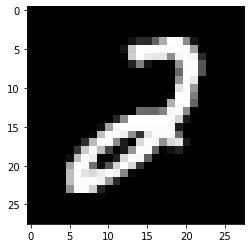

Label: 2


In [ ]:
# image 출력
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
# 2. 모델 구성
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(10, input_shape=(1, ), activation='relu'))
model.add(Dense(10))
model.add(Dense(8))
model.add(Dense(10))

In [ ]:
x_train, y_train, x_val, y_val, x_val_1, y_val_1, x_val_2, y_val_2, x_test, y_test = idx_data_fold_0, idx_lb_fold_0, idx_data_fold_1, idx_lb_fold_1, idx_data_fold_2, idx_lb_fold_2, idx_data_fold_3, idx_lb_fold_3, idx_data_fold_4, idx_lb_fold_4

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
num_classes = 10
input_shape = (28, 28, 1)

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_val = np.expand_dims(x_val, -1)
x_val_1 = np.expand_dims(x_val_1, -1)
x_val_2 = np.expand_dims(x_val_2, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert one hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_val_1 = keras.utils.to_categorical(y_val_1, num_classes)
y_val_2 = keras.utils.to_categorical(y_val_2, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (14004, 28, 28, 1)
14004 train samples
13984 test samples


In [ ]:
import tensorflow as tf
# 3. 훈련
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['acc'])



m1 = model.fit(x_train, y_train, epochs=3, batch_size=1, validation_data=(x_test, y_test))
m2 = model.fit(x_val, y_val, epochs=3, batch_size=1, validation_data=(x_test, y_test))
m3 = model.fit(x_val_1, y_val_1, epochs=3, batch_size=1, validation_data=(x_test, y_test))
m4 = model.fit(x_val_2, y_val_2, epochs=3, batch_size=1, validation_data=(x_test, y_test))

Epoch 1/3


ValueError: ignored

In [ ]:
print(m1.history)
print(m2.history)
print(m3.history)
print(m4.history)

{'loss': [0.09000319987535477, 0.09000319987535477, 0.09000319987535477], 'mse': [0.09000292420387268, 0.09000292420387268, 0.09000292420387268], 'val_loss': [0.09000325202941895, 0.09000325202941895, 0.09000325202941895], 'val_mse': [0.09000292420387268, 0.09000292420387268, 0.09000292420387268]}
{'loss': [0.09000320732593536, 0.09000319987535477, 0.09000319987535477], 'mse': [0.09000292420387268, 0.09000292420387268, 0.09000292420387268], 'val_loss': [0.09000325202941895, 0.09000325202941895, 0.09000325202941895], 'val_mse': [0.09000292420387268, 0.09000292420387268, 0.09000292420387268]}
{'loss': [0.09000319987535477, 0.09000319987535477, 0.09000319987535477], 'mse': [0.09000292420387268, 0.09000292420387268, 0.09000292420387268], 'val_loss': [0.09000325202941895, 0.09000325202941895, 0.09000325202941895], 'val_mse': [0.09000292420387268, 0.09000292420387268, 0.09000292420387268]}
{'loss': [0.09000319987535477, 0.09000319987535477, 0.09000319987535477], 'mse': [0.09000292420387268, 

No handles with labels found to put in legend.


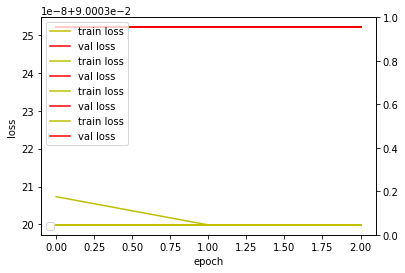

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(m1.history['loss'],'y',label='train loss')
loss_ax.plot(m1.history['val_loss'],'r',label='val loss')

loss_ax.plot(m2.history['loss'],'y',label='train loss')
loss_ax.plot(m2.history['val_loss'],'r',label='val loss')

loss_ax.plot(m3.history['loss'],'y',label='train loss')
loss_ax.plot(m3.history['val_loss'],'r',label='val loss')

loss_ax.plot(m4.history['loss'],'y',label='train loss')
loss_ax.plot(m4.history['val_loss'],'r',label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

In [ ]:
# 3. 훈련
model.compile(loss='mse', optimizer='adam', metrics=['acc'])
model.fit(x_train, y_train, epochs=50, batch_size=1, validation_data=(x_val, y_val))

Epoch 1/50
14004/14004 [==============================] - 52s 4ms/step - loss: 0.0900 - acc: 0.9000 - val_loss: 0.0900 - val_acc: 0.9000
Epoch 2/50
14004/14004 [==============================] - 50s 4ms/step - loss: 0.0900 - acc: 0.9000 - val_loss: 0.0900 - val_acc: 0.9000
Epoch 3/50
14004/14004 [==============================] - 49s 3ms/step - loss: 0.0900 - acc: 0.9000 - val_loss: 0.0900 - val_acc: 0.9000
Epoch 4/50
14004/14004 [==============================] - 52s 4ms/step - loss: 0.0900 - acc: 0.9000 - val_loss: 0.0900 - val_acc: 0.9000
Epoch 5/50
14004/14004 [==============================] - 52s 4ms/step - loss: 0.0900 - acc: 0.9000 - val_loss: 0.0900 - val_acc: 0.9000
Epoch 6/50
14004/14004 [==============================] - 49s 4ms/step - loss: 0.0900 - acc: 0.9000 - val_loss: 0.0900 - val_acc: 0.9000
Epoch 7/50
14004/14004 [==============================] - 46s 3ms/step - loss: 0.0900 - acc: 0.9000 - val_loss: 0.0900 - val_acc: 0.9000
Epoch 8/50
14004/14004 [=================

In [ ]:
# 4. 평가 예측
loss, mse = model.evaluate(x_test, y_test, batch_size=1)
print('acc : ', mse)
 
y_predict = model.predict(x_test)
#print(y_predict)


14004/14004 [==============================] - 21s 2ms/step - loss: 0.0900 - mse: 0.0900
acc :  0.09000292420387268


In [ ]:
 
# RMSE 구하기
from sklearn.metrics import mean_squared_error
def RMSE(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))
print('RMSE : ', RMSE(y_test, y_predict)) 
 
# R2 구하기
from sklearn.metrics import r2_score
r2_y_predict = r2_score(y_test, y_predict)
print('R2 : ', r2_y_predict)

